<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 6 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 7 October 2019, with material from Thomas Wiecki</div>

# Metropolis explained

In class, many of you said you wanted to know how [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) works, so here it is.

## Formulas

In the philosophy of decision making, **Bayesian inference** is closely related to **Bayesian probability**, in the sense that it manipulates **priors**, **evidence**, and **likelihood** to compute the **posterior**. 

Given some event B, what is the probability that event A occurs?. 

This is answered by Bayes' famous formula: $P(A/B)=\dfrac{P(B/A)P(A)}{P(B)}$

* $P(A/B)$ is the **posterior**. What we wish to compute.

* $P(B/A)$ is the **likelihood**. Assuming A occured, how likely is B.

* $P(A)$ is the **prior**. How likely the event $A$ is regardless of evidence.

* $P(B)$ is the **evidence**. How likely the evidence $B$ is regardless of the event.

In our case, we are mostly interested in the specific formulation of Bayes' formula:

$P(\theta/D)=\dfrac{P(D/\theta)P(\theta)}{P(D)}$ where, $P(\theta/D)$ is the **posterior**, $P(D/\theta)$ is the **likelihood**, $P(\theta)$ is the **prior** and $P(D)$ is the **evidence**.

## Frequentist vs Bayesian thinking

There are two major interpretations to probabilities: Bayesian and Frequentist. 

We began our class with a **Frequentist's** perspective, probabilities represent long term frequencies with which events occur: number of favorable events over number of all possible events. A frequentist says that the probability of having **tails** from a coin toss is equal to 0.5 *on the long run*. Each new experiment, a **Bernoulli trial**, can be considered as one of an infinite sequence of possible repetitions of the same experiment. The idea is that there is ***no belief*** in a frequentist's view of probability. The probability of event $x$ happening out of $n$ trials is equal to the following frequency: $p(x)=\dfrac{\text{number of $x$'s}}{n}$, and the true probability is reached when $n->\infty$. Frequentists will never say ***I am 75% (0.75) sure that Lewis Hamilton will win the 2019 F1 season*** before the season ends. When the season ends, he can say Lewis Hamilton has a probability of winning a F1 season equal to the number of points he won over the number of total points awarded in 2019, but even that is a stretch for a frequentist because he has to repeat the experiment over all possible F1 seasons that include LH. Commonly, a frequentist approach is referred to as the **objective** approach since there is no expression of belief.

On the other hand, in **Bayesian** thinking, probabilities are treated as an expression of **belief**. Therefore it is perfectly reasonable for a Bayesian to say ***I am 75% (0.5) sure that Lewis Hamilton will win the 2019 F1 season***. By combining **prior** beliefs and current events (the **evidence**) one can compute the **posterior**, the belief that Lewis Hamilton will win the 2019 F1 season. The idea behind Bayesian thinking is to keep updating your beliefs as more evidence is provided. Since this approach deals with belief, it is usually referred to as the **subjective** view on probability.

## The difficulty in Bayes' Formula

The **prior** is what you beleive about something, ***usually about a parameter in your model***, for example, how fair are the two dice, how much do you believe in the power of the Hamilton, etc. Then you get some **evidence**, such as F1 wins, and your belief about the parameter gets updated, sometimes reinforced, sometimes not. 

MCMC algorithms like the [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) takes in your model for the dependent variable $y$ (*conditioned* on a parameter $\theta$) called the **likelihood**, your model(s) for the parameter(s) $\theta$ called the **prior**, and given the **evidence** that the data $y$ was indeed generated by your model, builds an updated belief about the parameter $\theta$ (the **posterior**).

[Bayes formula](https://en.wikipedia.org/wiki/Bayes%27_theorem) is how we compute the posterior:

$$p(\theta\;|\;y) = \frac{p(y\;|\;\theta) \;p(\theta)}{p(y)}$$

Our **posterior**, $p(\theta\;|\;y)$, is the probability for our model parameter $\theta$ conditioned on the observations, i.e. the dependent variable $y$ ($y$ is a **vector** for discrete random variables that is usually given by a probability distribution in the form of a dictionary, and a **function** for continuous random variables usually given by a function definition but could also be approximated by a dictionary). To compute this, we multiply the **prior** $p(\theta)$ (what we think about $\theta$ before we see any observations) with the **likelihood** $p(y\;|\;\theta)$, which is how we think our data is distributed. Then we divide by something...

That something, $p(y)$, is called the **evidence**: Evidence that the data $y$ was indeed generated by your model. This quantity is **conditioned** on all possible values of the parameter $\theta$. For continuous variables, we compute this quantity by integrating over all possible parameter values (a sum instead for discrete variables):

$$p(y) = \int_\theta p(y, \theta) \, \mathrm{d}\theta$$

***That*** is the key difficulty with Bayes formula: For even slightly non-trivial models ***you can't compute the posterior in a closed-form way***. 

## An approximation then?

There exist a class of algorithms called [**Markov chain Monte Carlo**](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) that construct a **Markov chain** (where each step in state space like steps we used to do genetic programming are memoryless) to do a **Monte Carlo** (using a random variable) approximation.

## Generating some data

Lets generate 100 points from a normal distribution with a zero mean. Our goal will be to estimate the posterior of the mean `mu` (we'll assume that we know the standard deviation to be 1). We know we start with a zero mean, so we know what we should end up with if our reasoning is correct.

In [2]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

Numpy's `random.randn()` generates random variates according to a **normal** distribution. This is what the $y$'s look like. Run the cell below many times to see that, indeed, you get random-looking data.

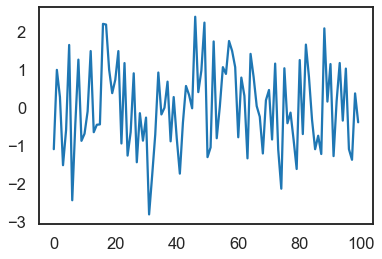

In [3]:
data = np.random.randn(100)
plt.plot(data)

and yet, even though the data is random, the histogram of the data reveals that some values $y$ happen **more often** than others. 

It's the same with your emails. Sometimes you receive 0 emails, sometimes 100 in a day. But most of the time, you receive a dozen. You know your emails are Poisson-distributed, but here we have a normal distribution.

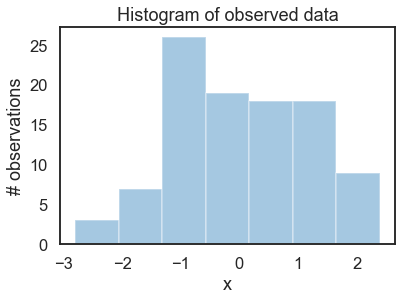

In [4]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

## Our model

We will assume we did not know how the data was generated. But by looking at the historgram above, we will assume that these observations are **gaussian** distributed, i.e. the **likelihood** of the model is **normal**. 

As you know, a normal distribution has two parameters **mean** $\mu$ and **standard deviation** $\sigma$. For simplicity, we'll assume we know that $\sigma = 1$ and we want to infer the posterior for $\mu$. 

For each parameter we want to infer, we have to chose a **prior**. For simplicity, let's also assume a normal distribution as a prior for $\mu$. Thus, in statistical speak our model for prior and likelihood is:

$$p(\mu) = \text{Normal}(0, 1)\\
p(y\;|\;\mu) = \text{Normal}(y; \mu, 1)$$

What is convenient is that for this model, we can actually compute the posterior **analytically** (some of you did this for your MLE hw). That's because for a normal likelihood with known standard deviation, the normal prior for `mu` is [**conjugate**](https://en.wikipedia.org/wiki/Conjugate_prior). **Conjugate** means that your posterior will follow the ***same*** distribution as your prior, so we know that your posterior for $\mu$ is ***also normal***. 

You can look up on wikipedia how we can compute the parameters of the posterior. For a mathematical derivation, see [here](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM). So here's the analytic solution.

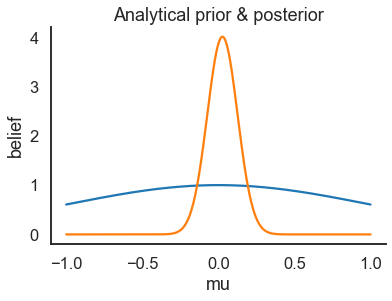

In [6]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
prior_analytical = gaussian(x, 0., 1.)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, prior_analytical)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical prior & posterior');
sns.despine()

 So that's the probability of $\mu$'s values after having seen the data, taking our prior information into account. Centered around 0 with a pretty small standard deviation.
 
 But what if we're not good at math?

## Not good at math, no problem!

Let's ***guess*** the first value of $\mu$, then use a program (Monte Carlo) that generates **random variables** to guess another value, *and so on*.

```python
mu_current = 1.
```

Now, you propose to move (jump) from that position in parameter state space (the 2D space $(\mu, \sigma)$ ***randomly*** (that's the **Monte Carlo** part) somewhere else (the **Markov** part is you don't care about where you where before `mu_current`). 

You can be very dumb or very sophisticated about how you come up with that proposal. The Metropolis **sampler** is very dumb and just takes a sample from a normal distribution (***no relationship to the normal we assume for our model***), centered around your current `mu` value (i.e. `mu_current`), and with a certain standard deviation (`proposal_width`) that will determine how far you propose jumps. Let's use `scipy.stats.norm`:

```python
proposal = norm(mu_current, proposal_width).rvs()
```

Yup, that's right, instead of a genetic algorithm (GA) where we move *somewhat intelligently* to a new position in state space that increases fitness, we use a pdf that is a gaussian which will produce simple random variates with a certain distribution that will generate new values for our parameters. 

The most likely position will be to stay where we are (because the pdf is normal centered around the current value for the parameter), but other positions are possible, including, with very small probability, all the way out to 3 standard deviations.

Next, you evaluate whether that's a ***good place to jump to or not***. If the resulting normal distribution with that proposed new `mu` explains the data better than your old `mu_current`, you'll definitely want to go there. 

But what does ***explains the data better*** mean? We already did this together when we looked at **Maximum Likelihood estimation** (MLE): We quantify **fit** by computing the probability that we observe the data, given the likelihood (normal) with the proposed parameter values (proposed new `mu` and fixed `sigma = 1`). 

This can be computed by calculating the probability for each individual observation $y$ using `scipy.stats.normal(mu, sigma).pdf(y)` and then multiplying all of them since we want to observe ***one data point after another***, like a succession of coin flips for which we know the result. That is how we compute the **likelihood**. Usually, you would use **log** probabilities to work with *sums* instead of *products* because sums overflow a lot less than products do, but we don't have to do this here because we only have 100 datapoints (actually, we will see we do end up in trouble and underlow to zero in our simulations).

Note that `.pdf(data)` returns a **vector**, and `v.prod()` takes the product of each element of `v` and this returns a **scalar** (a number).

### before and after *Likelihoods*:
```python
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
```

### before and after *priors*:    
```python
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
prior_proposal = norm(mu_proposal_mu, mu_proposal_sd).pdf(mu_proposal)
```

### before and after *nominators* in Bayes formula:
```python
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

```

So, we have a hill-climbing algorithm that would propose movements into random directions in state space (here, our state space is 1D since only one parameter is unknown) and only accept a jump if `mu_proposal` yields higher likelihood `p_proposal` than that of `mu_current`, which is `p_current`. 

Actually, we said we would only accept a jump if `mu_proposal` yields higher `likelihood_proposal` than `likelihood_current`, but bear with me because if we stick with `p_proposal` versus `p_current`, something very interesting happens..

Eventually we'll get to `mu = 0` (or close to it) from where no more moves will be possible because improvements won't be possible anymore. 

However, what we're after is to be able to produce ***variates*** from a posterior pdf that is unknown: We say we want to **sample from a pdf**. In order to reproduce all possible variates independently of where we start with our initial parameter guess, we'll also have to sometimes accept moves into the other direction (yielding lower likelihood). The key trick is by dividing the two probabilities

```python
p_accept = p_proposal / p_current
```

to get an **acceptance probability**. If `p_proposal` is larger, `p_accept` will be `> 1` and we'll ***definitely accept the move***. However, if `p_current` is larger, say twice as large, we'll say that there is only a 50% chance of moving there, and we ***move there with that probability in mind***. So the key predicate is:

```python
accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal

```

This simple procedure gives us samples from the posterior!

## Why?
Well, this seems awfully simple, doesn't it? But really, this simple acceptance ratio is the reason this algorithm works out and we get around the difficult integration in the denominator of Bayes' formula. 

We can show this by computing the acceptance ratio over the normalized posterior (with denominator) and see how it's equivalent to the acceptance ratio of the unnormalized posterior (no denominator, what we called `p_proposal` and `p_current`).

Lets say $\mu_0$ is our current position, and $\mu$ is our proposal:

$$ \frac{\frac{p(y\;|\;\mu) \;p(\mu)}{p(y)}}{\frac{p(y\;|\;\mu_0) \;p(\mu_0)}{p(y)}} = \frac{p(y\;|\;\mu) \;p(\mu)}{p(y\;|\;\mu_0) \;p(\mu_0)}$$

Dividing the posterior of the proposed parameter setting by the posterior of the current parameter setting, $p(y)$, ***that nasty quantity we can't compute***, gets canceled out! 

So our algorithm is actually dividing the ***full*** posterior at *one position* by the ***full*** posterior *at another position*, and we're visiting regions of high posterior probability *relatively* more often than those of low posterior probability. So we're actually sampling from the posterior, without even having an analytic formula for the posterior! 

Regions of ***high*** posterior probability is where we want to sample ***more*** from. Regiong of ***low*** posterior probability is where we want to sample ***less*** from, and we want to sample according to the probability of getting that sample. And that is what our simple algorithm does!

### Putting it all together

In [6]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    
    for i in range(samples):
        
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        # Compute Bayes' nominator
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

### Visualization

To visualize the sampling, we'll create plots for some quantities that are computed. Each row will be a single iteration through our Metropolis sampler. 

The first column is our **prior distribution**, what our belief about $\mu$ is before seeing the data. You can see how the distribution is static and we only plug in our $\mu$ proposals. The vertical lines represent our current $\mu$ in blue and our proposed $\mu$ in either red (if rejected) or green (if accepted). 

The 2nd column is our **likelihood distribution** and what we are using to evaluate how well our model explains the data (since we did not take logs, we multiply by 100 values less than 1, and sure enough we underflow to zero :-(). But you can see that the likelihood function changes in response to the proposed $\mu$. The blue histogram is our data. The solid line in green or red is the likelihood with the currently proposed `mu`. Intuitively, the more overlap there is between likelihood and data, the better the model explains the data and the higher the resulting probability will be. The dotted line of the same color is the proposed `mu` and the dotted blue line is the current `mu`.

The 3rd column is our **posterior distribution**. Here we display the normalized posterior but as we found out above, we can just multiply the prior value for the current and proposed $\mu$'s by the likelihood value for the two $\mu$'s to get the unnormalized posterior values (which we use for the actual computation), and divide one by the other to get our acceptance probability.

The 4th column is our **trace** (the posterior samples of $\mu$ we're generating) where we store each sample irrespective of whether it was accepted or rejected (in which case the line just stays constant).

Note that the algorithm says that we ***always*** move to relatively more likely $\mu$ values (in terms of their posterior density), but ***only sometimes*** to relatively less likely $\mu$ values (iteration number can be found at the top center of each row).

In [7]:
# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # plot Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # plot Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

Let's set a random seed and sample 8 values of $\mu$ from our posterior. Our initial guess for the mean will be -1.

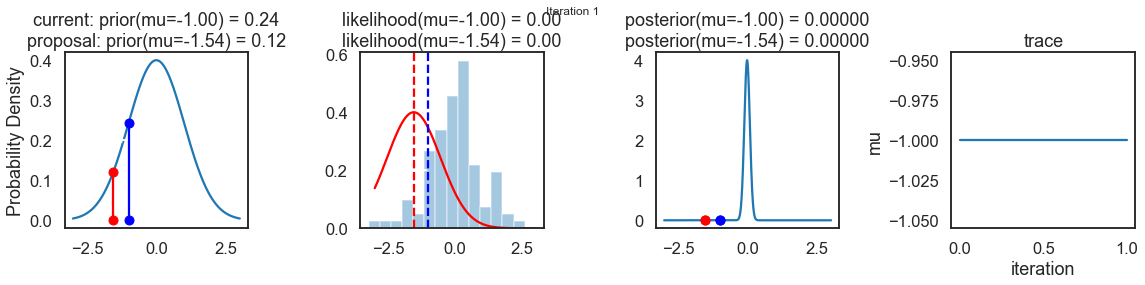

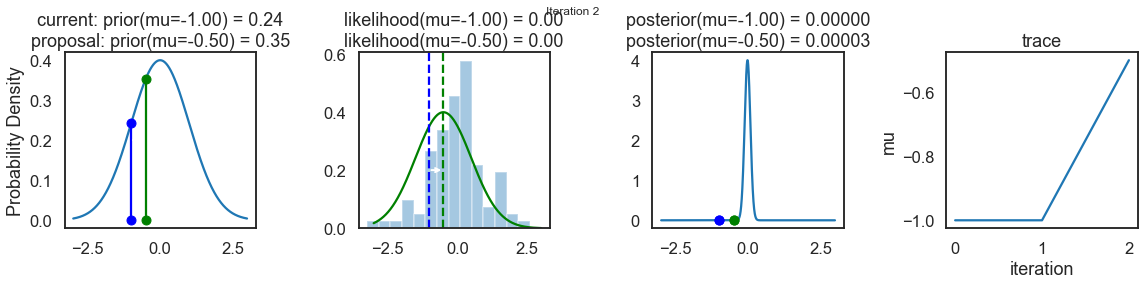

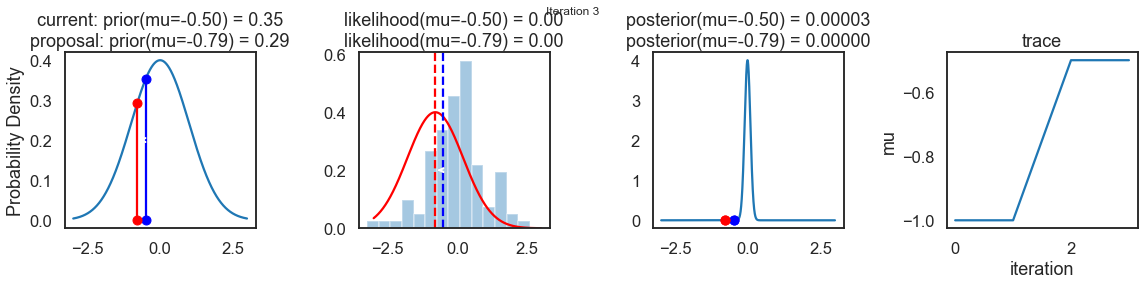

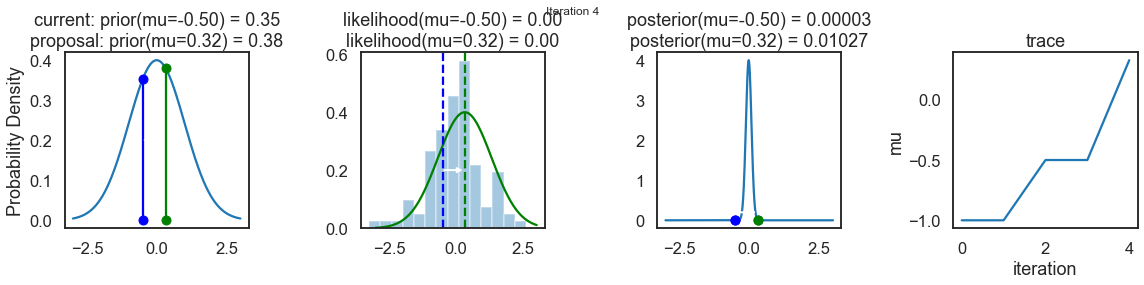

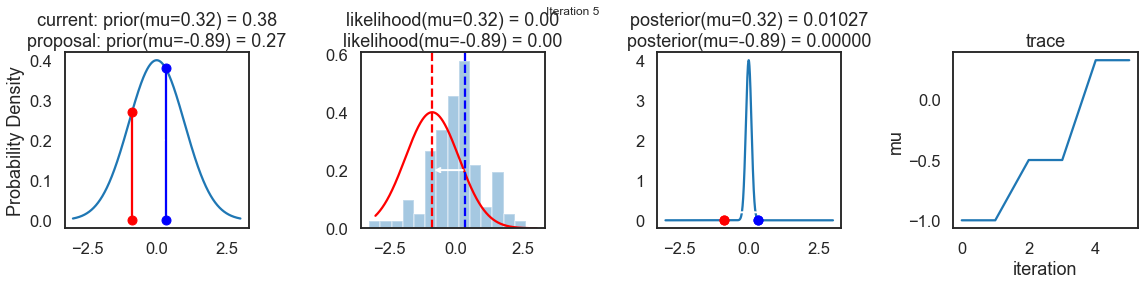

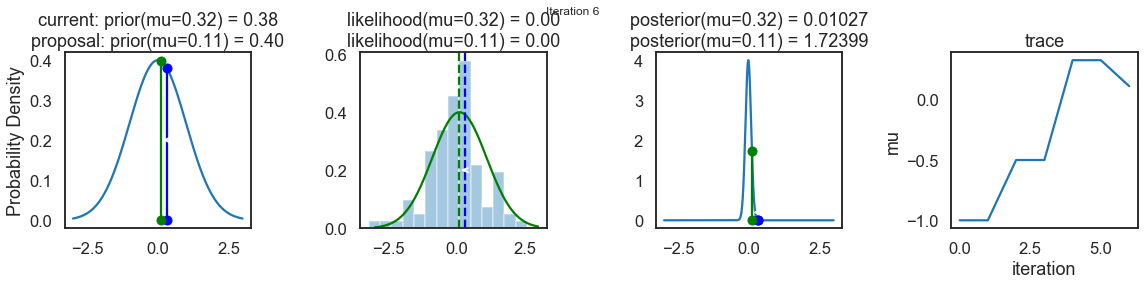

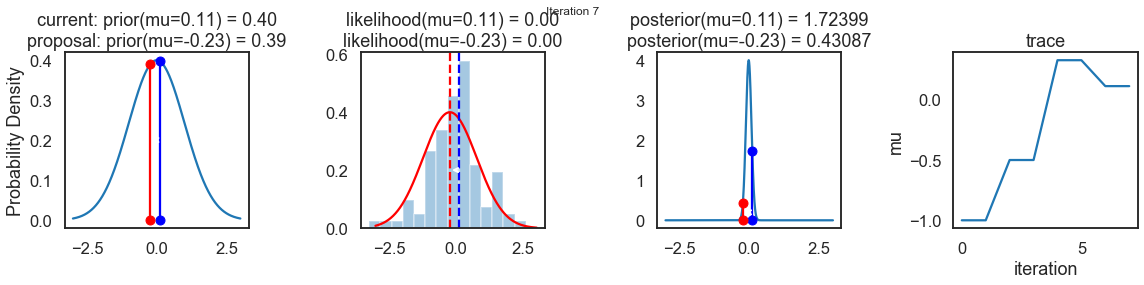

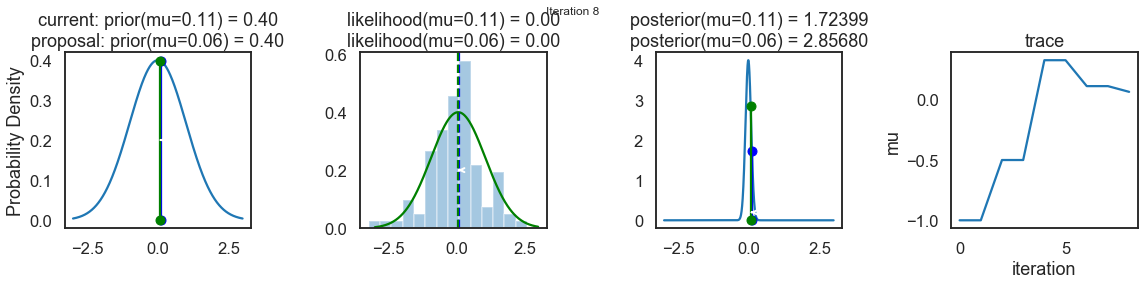

In [8]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

To get a sense of what our sampler produces, lets draw a lot of samples and plot them (not the intermediate steps, just all the values of the parameter $\mu$ that we generate with the Metropolis algorithm:

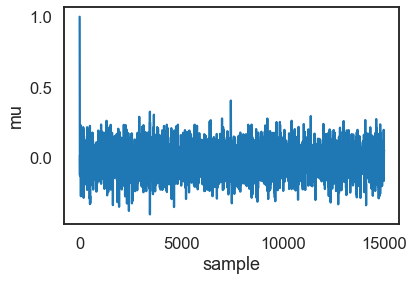

In [9]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

This is usually called the **trace** of our simulation. 

To now get an **approxmation** of the posterior (the reason why we're doing all this), we simply take the histogram of this trace, to see ***which values we generate more often***!. We also superimpose our analytic solution for the posterior, from way above in our notebook.

It's important to keep in mind that although this may look similar to the **data** we sampled above to fit the model, the two are completely separate things: The plot right below represents our **belief** in `mu`. In this case it just happens to also be normally distributed, like our data.

For a different model, it could have a completely different shape than the likelihood or prior.

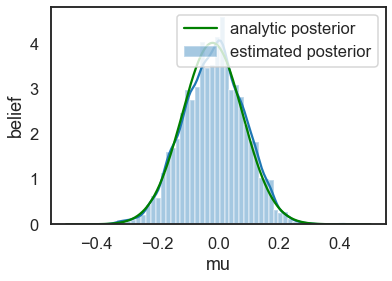

In [10]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

So you can see, by following the Metropolis algorithm, we get samples from the same distribution as what we derived analytically.

Neat, huh? And we did this without being good at math! Maybe this was you during math class:

<br />
<center>
    <img src="images/Calvin_and_hobbes._teacher.gif" width=600 />
</center>

## Effect of the proposal width

Above in `def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.)`, we set the proposal width to `0.5`. 

That turned out to be a pretty good value. In general you don't want the width to be too narrow because your sampling will be inefficient as it takes a loooooooong time to explore the whole parameter space and exhibits typical random-walk behavior:

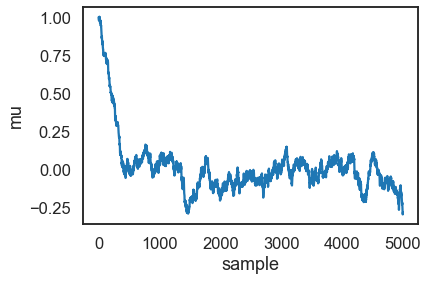

In [11]:
from scipy.stats import norm
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

But you also don't want it to be so large that you would ***never accept a jump***:

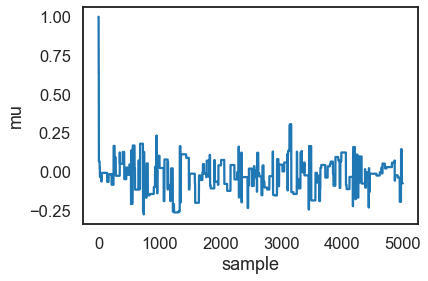

In [12]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

In both cases, you are still sampling from your target posterior distribution here as guaranteed by a mathemtical proof, just ***much less efficiently***:

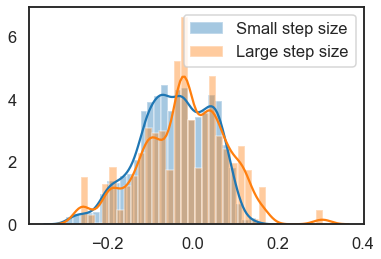

In [13]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend();

With more samples, both will eventually look like the true posterior. The key is that we want our samples to be independent of each other. 

Thus, one common metric to evaluate the efficiency of our sampler is **autocorrelation**, i.e. *how correlated a sample `i` is to sample `i-1`, `i-2`, etc.*

(your professor has a problem with the cell below. Need to google pymc3's `autocorr` API..)

In [16]:
import pymc3
from pymc3.stats import autocorr
autocorr(posterior_large, 1)

AttributeError: 'list' object has no attribute 'mean'

import pymc3
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pymc3.stats import autocorr
#steps_back = np.arange(1, 100)
steps_back = range(1,100)
fig, ax = plt.subplots()

ax.plot(steps_back, [autocorr(posterior_large, l) for l in steps_back], label='large step size')
ax.plot(steps_back, [autocorr(posterior_small, l) for l in steps_back], label='small step size')
ax.plot(steps_back, [autocorr(posterior, l) for l in steps_back], label='medium step size')
ax.legend(loc=0)
_ = ax.set(xlabel='steps back', ylabel='autocorrelation', ylim=(-.1, 1))

What's a smart way of figuring out the right step width automatically? One commonly used method is to keep adjusting proposal width so that roughly 50% proposals are rejected.

## Extending to more complex models

Now you can imagine that we could also add a `sigma` parameter for the standard-deviation and follow the same procedure for this second parameter. 

In that case, we would be generating proposals for `mu` *and* `sigma` but the algorithm logic would be nearly identical. 

We could also have data from a very different distribution of our data, like a Binomial, and still use the same algorithm and get the correct posterior! That's pretty cool and a huge benefit of probabilistic programming: Just define the model you want and let MCMC take care of the inference.

For example, the below model can be written in `PyMC3` quite easily. Below we also use the Metropolis sampler (which automatically tunes the proposal width) and see that we get identical results. Play around with this and change the distributions!

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Sampling 4 chains: 100%|██████████| 62000/62000 [00:30<00:00, 2056.52draws/s]
The number of effective samples is smaller than 25% for some parameters.


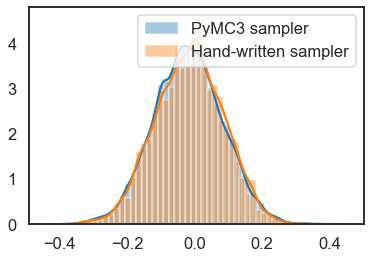

In [17]:
import seaborn as sns
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step)
    
sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler');
# The first 20% result are wrong
sns.distplot(posterior[500:], label='Hand-written sampler');
plt.legend();

# Conclusion

A simple algorithm that relies on a chain of random processes and on a semi-intelligent procedure for whether to accept the new random value or not based on model likelihood estimates actually samples (i.e. generates variates) from an unknown and difficult to compute posterior distribution.

Bayesian estimation allows us to build a model for observations ***and to refine this model based on new evidence*** and generate random variates (from a posterior pdf) that take this new evidence into account. We can now estimate the probability of a Lewis Hamilton win at any point in time of the F1 season, based on how he's actually doing throughout the season.

In the case of F1, the number of datapoints is small and we may want to store complete probability distributions, in the form of dicitonaries, as our model. But when we have many many datapoints, or when we have continuous variables, building a **Bayesian model** is a drastic act of dimensionality reduction. Your brain loves that. And so do machines. 

In my opinion, the only reason we don't already have ***apparently intelligent*** robots among us is because we focus on building very complex data-intense ***single-focus*** programs with large ML frameworks like tensorflow, instead of building many simpler bayesian models and then putting them to work all together. That is what our brains are: many many low-dimensional models put together so that we can better predict life and plan for happiness.